# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link:https://colab.research.google.com/drive/1DmjMVdOMbUHlg_0HfUd9wmEaxo6qiEk4?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
#import libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Folder found! 
The training dataset has 1775  images (~80%)
The validation dataset has 221  images (~10%)
The test dataset has 223  images (~10%)
Labels in this batch: tensor([5, 5, 5, 0, 4, 2, 0, 1])


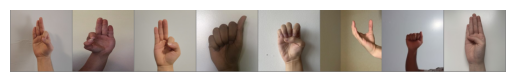

In [ ]:
# test to see if the path exists
data_root = '/content/drive/MyDrive/APS360Labs/lab3/Lab3_Gestures_Summer'

if os.path.exists(data_root):
    print("Folder found! ")
else:
    print("Folder not found! ")

#seed pytorch:
generator = torch.Generator().manual_seed(1000)

#now start the data splitting the data
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root = data_root,
                                           transform=transform)

# we split the data into 80%,10%,10%
train_length = int(0.8*len(dataset))
val_length = int(0.1*len(dataset))
#test_length = int(0.1*len(dataset))
test_length = len(dataset) - train_length - val_length
#have to do this because have to make sure we use whole dataset

#randomly split the datasets. This lets us have a good
#mix of different images in all sets, allowing us to
#have hands in the test that are never seen during training
trainset, valset, testset = torch.utils.data.random_split(dataset,
 [train_length, val_length, test_length], generator=generator)
print("The training dataset has", len(trainset), " images (~80%)")
print("The validation dataset has", len(valset), " images (~10%)")
print("The test dataset has", len(testset), " images (~10%)")



batch_size = 20
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)


#print some images for checking

# unnormalize and show images
def imshow(img):
    img = img * 0.5 + 0.5  # Unnormalize from [-1,1] to [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get one batch from train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the first 8 images
print("Labels in this batch:", labels[:8])
imshow(torchvision.utils.make_grid(images[:8]))


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
# I am using a CNN architecture with 2 conv layers.
# the first conv layer utlizes 5x5 kernals
# and then followed by relu activation and pooling. I then use
# another conv layer to change channel count to 10 using 5x5 kernal,
# also with relu activation and pooling. This allows us to
# reduce the dimension of the input while conserving important
# features. After two rounds of convolution and pooling, the output is
# flattened from 10×53×53 into a vector and passed through a fully connected
# layer with 32 hidden units, followed by a final linear layer that outputs
# class scores for the 9 labels. This allows us to extract and condense
# features, making it useful for image classification

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 9) #there are a total of 9 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
def get_accuracy(model, data_loader, train=False):

    correct = 0
    total = 0
    for imgs, labels in data_loader:


        #############################################
        #To Enable GPU Usage
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


def train(model, data, batch_size=64, learning_rate = 0.001, num_epochs=30,
          test = False):
    torch.manual_seed(1)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,

                                               shuffle = True)

    #see if we're testing a small dataset or not. If we are, just set
    #the val_loader as the train_loader
    if (test == False):
      val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                               shuffle=False)
    else:
      val_loader = train_loader

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


    iters, losses, train_acc, val_acc = [], [], [], []


    # training
    n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()        # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)       # compute *average* loss
            n+=1
        train_acc.append(get_accuracy(model, train_loader, train=True))
        # compute
        #training accuracy
        val_acc.append(get_accuracy(model,val_loader, train=False))  # compute
        #validation accuracy

        #print the information every epoch
        print(("Epoch {}: Train acc: {} |"+"Validation acc: {}").format(
                epoch + 1,
                train_acc[-1],
                val_acc[-1]))

    print('Training Finished')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()


    plt.title("Training Curve")
    plt.plot(range(1,num_epochs+1), train_acc, label="Train")
    if (test == False):
      plt.plot(range(1,num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

# The training function I implemented is designed to be flexible, allowing
# easy change of hyperparamaters. I used the CrossEntropyLoss
# as the loss function because it's well known and used for
# multiclassfification. I used SGD with momentum to avoid getting
# stuck in local minima. I also plot the training loss and accuracy
# for visualization, to oberserve how the model behaves with various number
# of epochs

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

CUDA is not available. Using CPU: 
Epoch 1: Train acc: 0.12 |Validation acc: 0.12
Epoch 2: Train acc: 0.12 |Validation acc: 0.12
Epoch 3: Train acc: 0.12 |Validation acc: 0.12
Epoch 4: Train acc: 0.16 |Validation acc: 0.16
Epoch 5: Train acc: 0.16 |Validation acc: 0.16
Epoch 6: Train acc: 0.16 |Validation acc: 0.16
Epoch 7: Train acc: 0.32 |Validation acc: 0.32
Epoch 8: Train acc: 0.28 |Validation acc: 0.28
Epoch 9: Train acc: 0.36 |Validation acc: 0.36
Epoch 10: Train acc: 0.72 |Validation acc: 0.72
Epoch 11: Train acc: 0.56 |Validation acc: 0.56
Epoch 12: Train acc: 0.52 |Validation acc: 0.52
Epoch 13: Train acc: 0.6 |Validation acc: 0.6
Epoch 14: Train acc: 0.64 |Validation acc: 0.64
Epoch 15: Train acc: 0.64 |Validation acc: 0.64
Epoch 16: Train acc: 0.8 |Validation acc: 0.8
Epoch 17: Train acc: 0.8 |Validation acc: 0.8
Epoch 18: Train acc: 0.48 |Validation acc: 0.48
Epoch 19: Train acc: 0.48 |Validation acc: 0.48
Epoch 20: Train acc: 0.44 |Validation acc: 0.44
Epoch 21: Train acc:

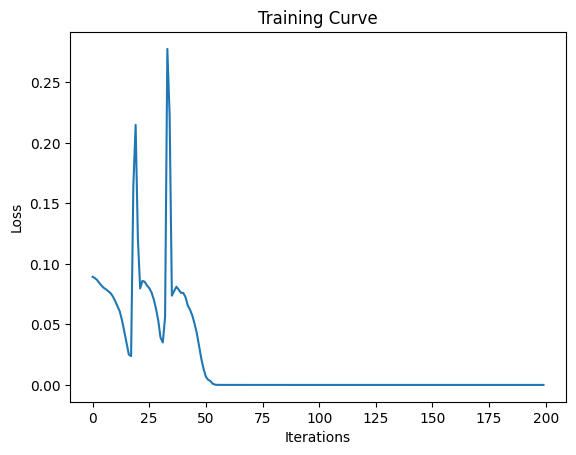

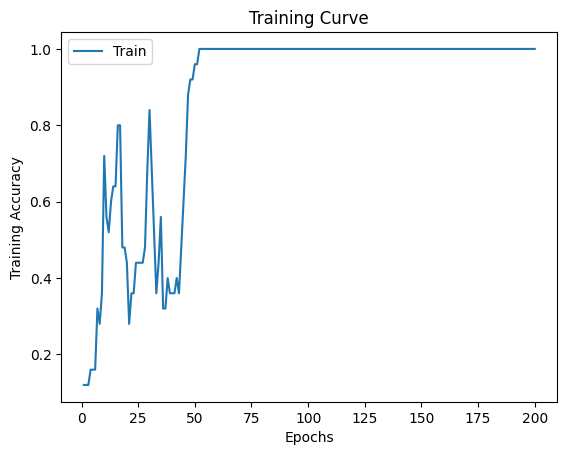

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:

import random
from torch.utils.data import Subset

random.seed(100)

# Select 25 random indices from the full trainset, to get a small dataset
small_subset_indices = random.sample(range(len(trainset)), 25)
small_dataset = Subset(trainset, small_subset_indices)

# Create a dedicated DataLoader for this test
small_loader = torch.utils.data.DataLoader(small_dataset, batch_size=25,
                                           shuffle=True)

# Save original loaders
original_train_loader = train_loader
original_val_loader = val_loader

# Replace loaders for training function
train_loader = small_loader
val_loader = small_loader
# Reuse same data for val because just testing the training


model = CNN()

if torch.cuda.is_available():
  model.cuda()
  print('CUDA is available! Using GPU: ')
else:
  print('CUDA is not available. Using CPU: ')
train(model, data=small_dataset, batch_size=25, learning_rate=0.01,
      num_epochs=200, test = True)

# Restore original loaders
train_loader = original_train_loader
val_loader = original_val_loader


# To test if the model is working properly, I tested the training on a small
#subset of of 25 images, and used a batch size of 25 with a
#learning rate of 0.01.

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
# I think 3 hyperparamaters that are worth tuning are:
# - stride
# - padding
# - Batch_size

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

CUDA is available! Using GPU: 
Epoch 1: Train acc: 0.11380281690140845 |Validation acc: 0.12217194570135746
Epoch 2: Train acc: 0.13859154929577464 |Validation acc: 0.13574660633484162
Epoch 3: Train acc: 0.3385915492957747 |Validation acc: 0.3076923076923077
Epoch 4: Train acc: 0.48732394366197185 |Validation acc: 0.46153846153846156
Epoch 5: Train acc: 0.584225352112676 |Validation acc: 0.5475113122171946
Epoch 6: Train acc: 0.660281690140845 |Validation acc: 0.6289592760180995
Epoch 7: Train acc: 0.7098591549295775 |Validation acc: 0.6289592760180995
Epoch 8: Train acc: 0.7008450704225352 |Validation acc: 0.6470588235294118
Epoch 9: Train acc: 0.7183098591549296 |Validation acc: 0.6199095022624435
Epoch 10: Train acc: 0.7216901408450704 |Validation acc: 0.665158371040724
Epoch 11: Train acc: 0.7549295774647887 |Validation acc: 0.6832579185520362
Epoch 12: Train acc: 0.7729577464788733 |Validation acc: 0.6425339366515838
Epoch 13: Train acc: 0.7684507042253521 |Validation acc: 0.6289

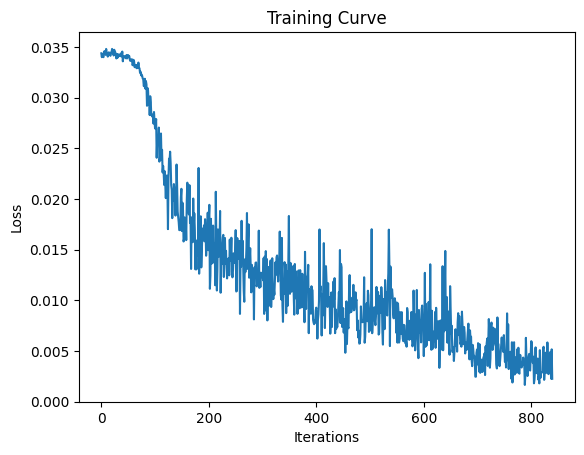

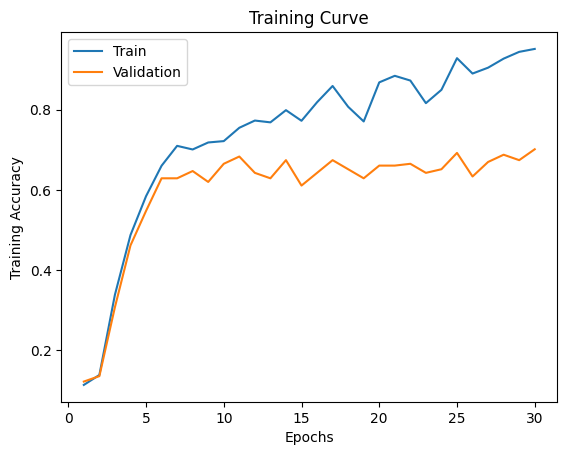

Final Training Accuracy: 0.9515492957746479
Final Validation Accuracy: 0.7013574660633484


In [ ]:
# lets start off with the accuracy originally
model = CNN()

if torch.cuda.is_available():
  model.cuda()
  print('CUDA is available! Using GPU: ')
else:
  print('CUDA is not available. Using CPU: ')

train(model, data=trainset, test = False)

CUDA is not available. Using CPU: 
Epoch 1: Train acc: 0.10535211267605633 |Validation acc: 0.09049773755656108
Epoch 2: Train acc: 0.10816901408450705 |Validation acc: 0.09049773755656108
Epoch 3: Train acc: 0.12338028169014084 |Validation acc: 0.10407239819004525
Epoch 4: Train acc: 0.13014084507042253 |Validation acc: 0.12217194570135746
Epoch 5: Train acc: 0.13633802816901408 |Validation acc: 0.1085972850678733
Epoch 6: Train acc: 0.15549295774647887 |Validation acc: 0.12217194570135746
Epoch 7: Train acc: 0.17690140845070423 |Validation acc: 0.15384615384615385
Epoch 8: Train acc: 0.2163380281690141 |Validation acc: 0.18552036199095023
Epoch 9: Train acc: 0.24732394366197183 |Validation acc: 0.19457013574660634
Epoch 10: Train acc: 0.2507042253521127 |Validation acc: 0.22624434389140272
Epoch 11: Train acc: 0.26704225352112676 |Validation acc: 0.24434389140271492
Epoch 12: Train acc: 0.3036619718309859 |Validation acc: 0.29411764705882354
Epoch 13: Train acc: 0.3171830985915493 |V

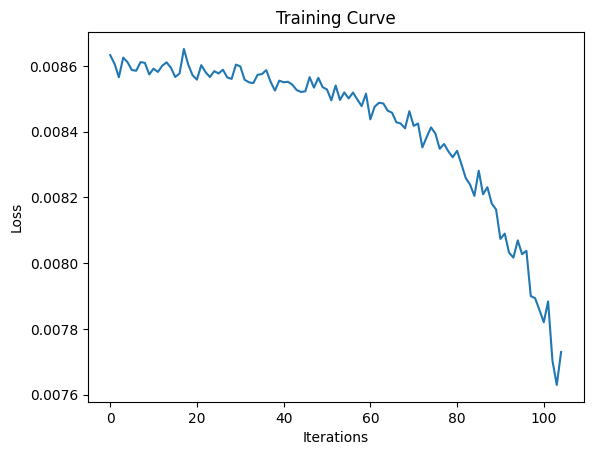

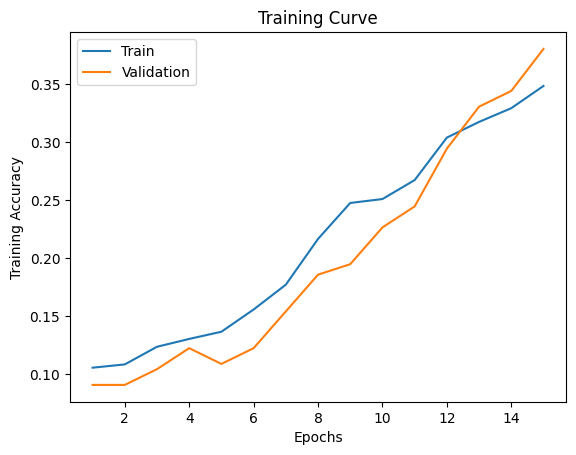

Final Training Accuracy: 0.34816901408450707
Final Validation Accuracy: 0.38009049773755654


In [ ]:
#  Now lets try changing the batch size
model2 = CNN()

if torch.cuda.is_available():
  model2.cuda()
  print('CUDA is available! Using GPU: ')
else:
  print('CUDA is not available. Using CPU: ')

train(model2, data=trainset, batch_size=256, test = False, num_epochs=15)

# I used a lower amount of epochs here because my GPU limit ran out
# and it was taking a really long time to train the data.

CUDA is not available. Using CPU: 
Epoch 1: Train acc: 0.11549295774647887 |Validation acc: 0.12669683257918551
Epoch 2: Train acc: 0.11380281690140845 |Validation acc: 0.12217194570135746
Epoch 3: Train acc: 0.11380281690140845 |Validation acc: 0.13574660633484162
Epoch 4: Train acc: 0.11267605633802817 |Validation acc: 0.13574660633484162
Epoch 5: Train acc: 0.1115492957746479 |Validation acc: 0.13122171945701358
Epoch 6: Train acc: 0.1104225352112676 |Validation acc: 0.13122171945701358
Epoch 7: Train acc: 0.11887323943661972 |Validation acc: 0.13574660633484162
Epoch 8: Train acc: 0.11492957746478873 |Validation acc: 0.12669683257918551
Epoch 9: Train acc: 0.11098591549295775 |Validation acc: 0.11312217194570136
Epoch 10: Train acc: 0.11774647887323944 |Validation acc: 0.1085972850678733
Epoch 11: Train acc: 0.11549295774647887 |Validation acc: 0.11764705882352941
Epoch 12: Train acc: 0.10985915492957747 |Validation acc: 0.10407239819004525
Epoch 13: Train acc: 0.11380281690140845 

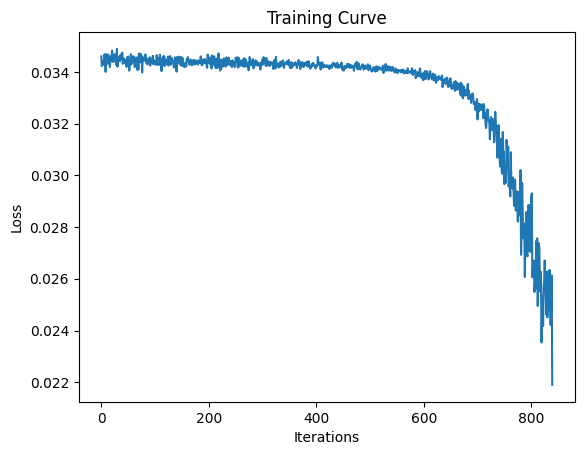

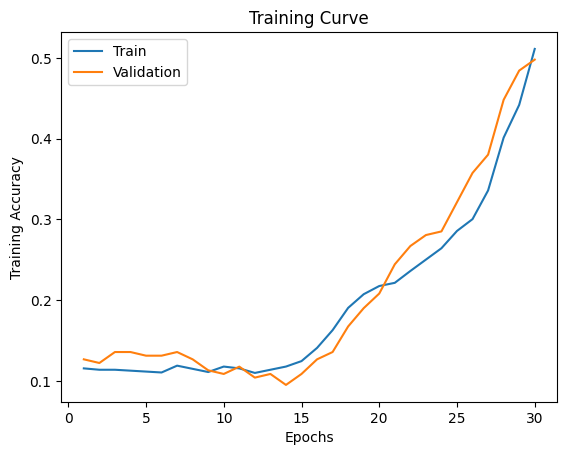

Final Training Accuracy: 0.5109859154929578
Final Validation Accuracy: 0.497737556561086


In [ ]:
# Update the CNN architecture's stride and padding

class updateCNN(nn.Module):
    def __init__(self):
        super(updateCNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, kernel_size=5, stride=3, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5, stride=3, padding=2)
        self.fc1 = nn.Linear(10 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

model3 = updateCNN()
if torch.cuda.is_available():
  model3.cuda()
  print('CUDA is available! Using GPU: ')
else:
  print('CUDA is not available. Using CPU: ')

train(model3, data=trainset, test = False)

CUDA is not available. Using CPU: 
Epoch 1: Train acc: 0.14535211267605633 |Validation acc: 0.11312217194570136
Epoch 2: Train acc: 0.15774647887323945 |Validation acc: 0.13122171945701358
Epoch 3: Train acc: 0.19042253521126762 |Validation acc: 0.13122171945701358
Epoch 4: Train acc: 0.20338028169014086 |Validation acc: 0.13574660633484162
Epoch 5: Train acc: 0.28901408450704225 |Validation acc: 0.19909502262443438
Epoch 6: Train acc: 0.4416901408450704 |Validation acc: 0.42081447963800905
Epoch 7: Train acc: 0.5538028169014084 |Validation acc: 0.5475113122171946
Epoch 8: Train acc: 0.5408450704225352 |Validation acc: 0.5475113122171946
Epoch 9: Train acc: 0.6287323943661972 |Validation acc: 0.6289592760180995
Epoch 10: Train acc: 0.6608450704225353 |Validation acc: 0.6153846153846154
Epoch 11: Train acc: 0.7126760563380282 |Validation acc: 0.6877828054298643
Epoch 12: Train acc: 0.6805633802816902 |Validation acc: 0.6289592760180995
Epoch 13: Train acc: 0.7295774647887324 |Validation

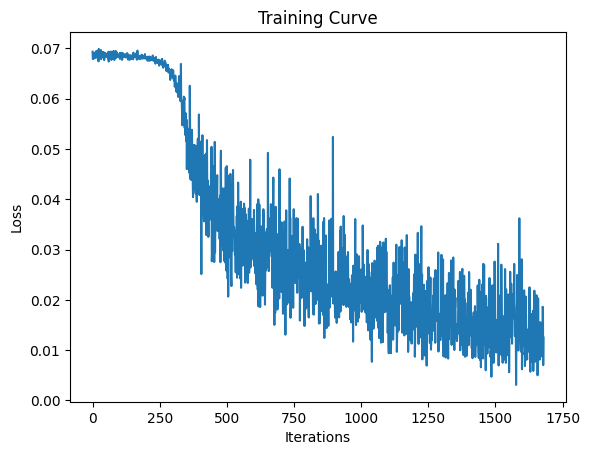

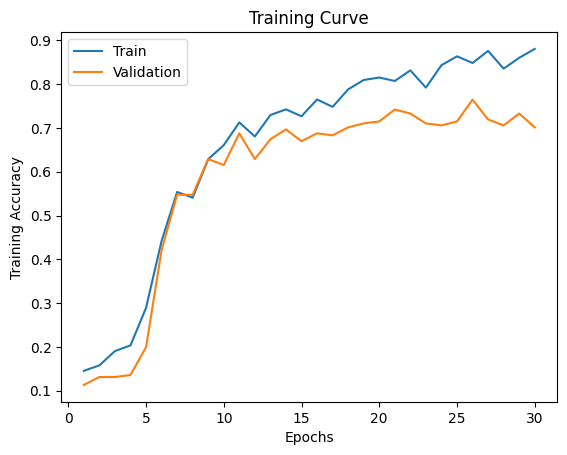

Final Training Accuracy: 0.8805633802816901
Final Validation Accuracy: 0.7013574660633484


In [ ]:
#now lets try decreasing batch size and making stride 2, and padding 1
class reUpdateCNN(nn.Module):
    def __init__(self):
        super(reUpdateCNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, kernel_size=5, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5, stride=2, padding=1)

        self.fc1 = nn.Linear(10 * 13 * 13, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # → 55x55x5
        x = self.pool(F.relu(self.conv2(x)))  # → 13x13x10
        x = x.view(-1, 10 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

model4 = reUpdateCNN()
if torch.cuda.is_available():
  model4.cuda()
  print('CUDA is available! Using GPU: ')
else:
  print('CUDA is not available. Using CPU: ')

train(model4, data=trainset, batch_size = 32, test = False)

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
#The best model out of all the ones I have trained was the last one,
# (model4) which was the one
# where I updated my CNN architecure, and updated the batch size

# 2 conv layers with stride 2 and padding 1
# included max pooling
# batch size reduced to size 32

# I chose this model because it resulted in the highest validation accuracy,
# with pretty stable performance. By setting the stride to 2 and padding to 1
# the model was able to lower the dimensions without losing too much
# important information. Also by reducing the batch size, the model
# was able to update the weigths more frequently, allowing it to better
# generalize data.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
test_accuracy = get_accuracy(model4,data_loader=test_loader, train=False)
print("Test Accuracy: ", test_accuracy*100, "%")

Test Accuracy:  72.6457399103139 %


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 101MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
#features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
def compute_features():
  letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

  # Create directories to store features in
  for split in ['train', 'val', 'test']:
      for letter in letters:
          os.makedirs(f'./AlexNet Features/{split}/{letter}', exist_ok=True)

  #batch_size of 1 makes it easy to store data with corresponding classes
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=
                                             True)
  val_loader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=True)
  test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

  i = 0
  for imgs, labels in iter(train_loader):
    features = alexnet.features(imgs)
    features = features.squeeze(0).detach()
    torch.save(features, './AlexNet Features/train/'+ letters[labels.item()] +
               '/'+'feature_' + str(i)+'.tensor')
    i+=1

  i=0
  for imgs, labels in iter(val_loader):
    features = alexnet.features(imgs)
    features = features.squeeze(0).detach()
    torch.save(features, './AlexNet Features/val/'+ letters[labels.item()] +'/'
    +'feature_' + str(i)+'.tensor')
    i+=1

  i=0
  for imgs, labels in iter(test_loader):
    features = alexnet.features(imgs)
    features = features.squeeze(0).detach()
    torch.save(features, './AlexNet Features/test/'+ letters[labels.item()] +'/'
    +'feature_' + str(i)+'.tensor')
    i+=1

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
#output = model(features)
#prob = F.softmax(output)

In [ ]:
class alexCNN(nn.Module):
    def __init__(self):
        super(alexCNN, self).__init__()
        self.name = "alexCNN"


        self.conv1 = nn.Conv2d(256, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 64)      # Fully connected layer
        self.fc2 = nn.Linear(64, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # conv,  ReLU , pool
        x = x.view(-1, 128 * 3 * 3)           # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

# I used a basic CNN that will take the output of the Alexnet features
# as inputs, and first reduces the channels to 128. I then use pooling
# to lower the dimension and keep key information/features. I then use
# fully connected layers to learn from extracted features and
# figure out which of the 9 classes it is

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

CUDA is not available. Using CPU: 
Epoch 1: Train acc: 0.5870422535211267 |Validation acc: 0.5927601809954751
Epoch 2: Train acc: 0.7436619718309859 |Validation acc: 0.755656108597285
Epoch 3: Train acc: 0.8602816901408451 |Validation acc: 0.8280542986425339
Epoch 4: Train acc: 0.8912676056338028 |Validation acc: 0.8778280542986425
Epoch 5: Train acc: 0.908169014084507 |Validation acc: 0.8687782805429864
Epoch 6: Train acc: 0.8980281690140846 |Validation acc: 0.8190045248868778
Epoch 7: Train acc: 0.9284507042253521 |Validation acc: 0.8823529411764706
Epoch 8: Train acc: 0.9498591549295775 |Validation acc: 0.9004524886877828
Epoch 9: Train acc: 0.9594366197183098 |Validation acc: 0.918552036199095
Epoch 10: Train acc: 0.9661971830985916 |Validation acc: 0.9095022624434389
Epoch 11: Train acc: 0.9740845070422535 |Validation acc: 0.9230769230769231
Epoch 12: Train acc: 0.9802816901408451 |Validation acc: 0.918552036199095
Epoch 13: Train acc: 0.9752112676056338 |Validation acc: 0.9095022

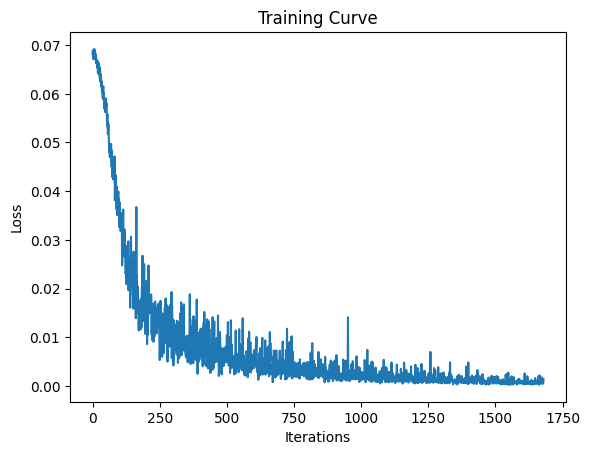

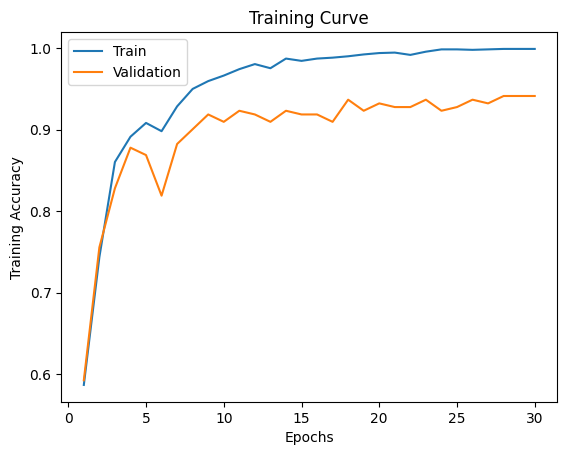

Final Training Accuracy: 0.9988732394366198
Final Validation Accuracy: 0.9411764705882353


In [ ]:
#tensor = torch.from_numpy(tensor.detach().numpy())
compute_features()
alexNetModel = alexCNN()

from torchvision.datasets import DatasetFolder

trainset = DatasetFolder('./AlexNet Features/train', loader=torch.load,
                         extensions=('.tensor',))
valset = DatasetFolder('./AlexNet Features/val', loader=torch.load,
                       extensions=('.tensor',))
testset = DatasetFolder('./AlexNet Features/test', loader=torch.load,
                        extensions=('.tensor',))
#val_loader = torch.utils.data.DataLoader(valset, batch_size=32)
#UPDATE VALSET AND TESTSET


if torch.cuda.is_available():
  alexNetModel.cuda()
  print('CUDA is available! Using GPU: ')
else:
  print('CUDA is not available. Using CPU: ')

train(alexNetModel, data=trainset, batch_size = 32, test = False)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
test_accuracy = get_accuracy(alexNetModel,data_loader=test_loader, train=False)
print("Test Accuracy: ", test_accuracy*100, "%")

#As we can see, the training, validation and test accuracy all
#significantly increased with transfer learning, when comapred
# to the accuracy's without transfer learning. By using
#what the model learned from Alexnet, our models accuracy
# increased because our dataset is relativaly small to learn
# really good from scratch

Test Accuracy:  92.82511210762333 %
